# **TP CNN**
L'objectif de ce TP est de vous faire coder un réseau de neurones à convolution (CNN), et de vous familiariser en même temps avec PyTorch, qui est une librairie permettant de coder ses propres réseaux de neurones! Ici, on va créer un réseau capable de détecter la présence d'Alzheimer ainsi que son intensité à l'aide d'IRM.
Je vous suggère d'exécuter ce code en ligne sur Google Colab ce sera bien plus simple pour l'import des librairies et vous pourrez utililser les GPU de google.

## I) Quelques rappels sur les CNN
Si vous avez manqué la formation théorique, vous pouvez toujours la retrouver sur le site des Automatants : https://automatants.cs-campus.fr/formations

Voici quelques informations sur les CNN pour vous remettre dans le bain :

### Un peu de théorie

Les CNNs sont spécifiquement faits pour travailler sur des images !

Chaque image est un tableau de taille *largeur x longueur x canaux* (les canaux peuvent être au nombre de 3 pour une image couleur ou 1 pour une image en nuances de gris). On applique alors un filtre, qui est un tableau de largeur et longueur inférieures, mais de nombres de canaux identiques ! Le filtre sert de coefficients pour sommer la valeur des pixels en dessous, et on décale le filtre jusqu'à avoir couvert toute l'image.

Ci-dessous un exemple.

![](https://miro.medium.com/max/413/1*4yv0yIH0nVhSOv3AkLUIiw.png)
![](https://miro.medium.com/max/268/1*MrGSULUtkXc0Ou07QouV8A.gif)

Voilà, quelques filtres communs, on voit que cela peut servir pour la détection de bord par exemple !

![](https://miro.medium.com/max/349/1*uJpkfkm2Lr72mJtRaqoKZg.png)

Il y a d'autres paramètres qu'on ne détaillera pas ici. Au sein d'une couche CNN, il peut y avoir plusieurs filtres. La sortie est alors une image de même largeur et longueur, mais le nombre de canaux est alors égale au nombre de filtres. L'entrainement d'un CNN revient à déterminer les coefficients de ces filtres.

Cependant, vous remarquerez qu'ici, on ne diminue pas la taille d'une image, mais qu'on joue seulement sur la profondeur de celle-ci (le nombre de canaux). Afin, de réduire la dimension de celle-ci, nous allons utiliser du `Pooling`, notamment, du `MaxPooling` qui revient à considérer la valeur maximale en déplaçant un filtre à chaque fois (Voir l'illustration ci-dessous).

![](https://miro.medium.com/max/602/1*SmiydxM5lbTjoKWYPiuzWQ.png)

La `MaxPooling` réduit donc la surface de l'image, tout en gardant la même profondeur. Par exemple, avoir un carré de *2x2* pour le `MaxPooling` divisera la largeur et la longeur de l'image sortante par 2.

Le fait de chaîner des CNNs permet au modèle d'apprendre des motifs complexes. Les premiers CNNs détecteront les bords, etc. Tandis que les suivants pourront agréger tout ça pour reconnaitre des formes plus évoluées. Après les CNNs, nous pouvons mettre un réseau dense, afin de faire la classification à partir des *features* extraites des CNNs.


On commence par importer les librairies que nous allons utiliser lors de ce TP

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

Le dataset vient du site kaggle (https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset), n'essayez pas de le télécharger à la main, ce serait trop long. On va l'importer directement de kaggle à colab grâce au commandes suivantes. Exécutez les cellules suivantes et le dataset sera importé dans googla colab.

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download uraninjo/augmented-alzheimer-mri-dataset
! unzip 'augmented-alzheimer-mri-dataset.zip'

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
augmented-alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  augmented-alzheimer-mri-dataset.zip
replace AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

La première étape consiste à charger nos données, en l'occurence des images de radios médicales. Si vous effectuez ce TP sur Google Colab, l'arborescence des fichiers est disponible tout juste à gauche du notebook.

In [4]:
train_dataset = datasets.ImageFolder(root = 'AugmentedAlzheimerDataset', transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
val_dataset = datasets.ImageFolder(root = 'OriginalDataset', transform = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_dataset)
val_loader = torch.utils.data.DataLoader(val_dataset)

La fonction `ImageFolder` crée un dataset à partir d'un dossier contenant des images. De plus, elle applique directement une transformation à ces images. Dans notre cas, on modifie la taille des images à 32x32 et on les convertit en tenseur.

Ensuite, on crée un `dataloader` à partir de ces dataset. Un dataloader est un objet itérable qui contient à la fois nos données et nos labels. C'est à partir de lui que l'on va créer X_train et Y_train.

In [5]:
train_size = len(train_dataset)
val_size = len(val_dataset)

X_train = np.empty((train_size, 3, 32, 32))
Y_train = np.empty(train_size)

X_val = np.empty((val_size, 3, 32, 32))
Y_val = np.empty(val_size)

for i, (image, label) in enumerate(train_loader) :
  X_train[i] = image.data[0]
  Y_train[i] = label.item()

for i, (image, label) in enumerate(val_loader) :
  X_val[i] = image.data[0]
  Y_val[i] = label.item()

Nous avons maintenant X_train et Y_train, nos données et labels d'entraînement ainsi que X_val et Y_val, nos données et labels de validation qu'on utilisera à la fin pour vérifier que notre modèle est bien entraîné.

Il convient maintenant d'effectuer quelques opérations sur X_train et Y_train afin de pouvoir les donner en entrée du modèle et de faciliter l'entraînement.

Dans un premier temps, nous allons mélanger nos données pour éviter de créer un biais dans notre réseau. Attention, il ne faut pas mélanger X et Y séparement sinon les données ne correspondraient plus aux labels. C'est pourquoi on crée d'abord une permutation aléatoire et on l'applique ensuite à X et Y.

In [6]:
permutation = np.random.permutation(len(X_train))
X_permuted, Y_permuted =  X_train[permutation], Y_train[permutation]

Pour avoir de meilleures performances, on va normaliser nos images : on passe de [0, 1] à [-1, 1]. On convertit ensuite notre array numpy en tensor torch. Enfin, on va découper notre jeu de données en batch. Cela signifie que nos données vont passer dans notre modèle par groupe (de 64 dans notre cas). Ceci permet d'accéler l'entraînement.

In [7]:
X_normalized = X_permuted*2 - 1
X_train = torch.tensor(X_normalized, dtype = torch.float32)
X_train_batches = X_train[: 33984].view(531, 64, 3, 32, 32)

Passons maintenant au traitement de Y. On va commencer par utiliser l'encodage onehot, comme au tp précédent. Cela va permettre de comparer notre vecteur de sortie du modèle à nos labels. Pour l'instant, les labels sont des nombres entre 0 et 3, on va les transformer en vecteur de dimension 4 : 2 devient [0, 0, 1, 0].
On fait ensuite le même découpage en batch que pour X.

In [8]:
Y_train_onehot = np.zeros((Y_permuted.size, 4))
Y_train_onehot[np.arange(len(Y_permuted)), Y_permuted.astype(int)] = 1
Y_train_tensor = torch.tensor(Y_train_onehot, dtype = torch.float32)
Y_train_batches = Y_train_tensor[: 33984].view(531, 64, 4)

On va également disposer d'un Y_train_predictions qui ne sera pas encodé en onehot, il sera composé des labels de départ (entre 0 et 3). Ceci permettera de comparer la prédiction de notre modèle avec la réalité, on pourra ainsi calculer l'accuracy.

In [9]:
Y_train_predictions = torch.tensor(Y_permuted, dtype = torch.float32)
Y_train_batches_predictions = Y_train_predictions[: 33984].view(531, 64)

Une fois que l'on a fait ça, on peut observer la dimension de X_train et Y_train

In [10]:
print(X_train_batches.shape)
print(Y_train_batches.shape)
print(Y_train_batches_predictions.shape)

torch.Size([531, 64, 3, 32, 32])
torch.Size([531, 64, 4])
torch.Size([531, 64])


On peut commencer par afficher quelques images de notre dataset avec leurs classes respectives

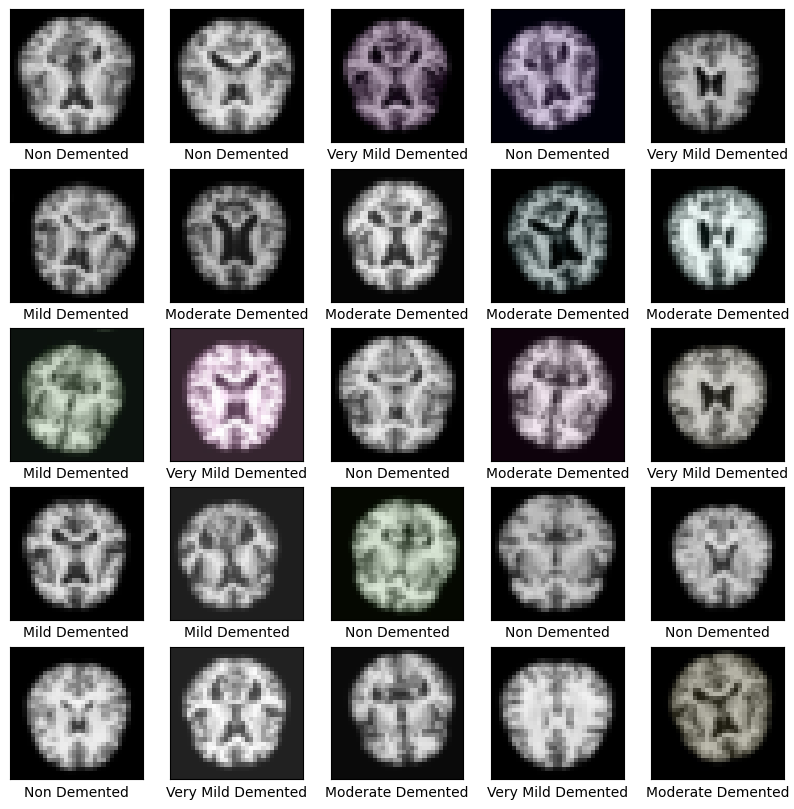

In [11]:
plt.figure(figsize=(10,10))

classes = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(X_permuted[i], (1, 2, 0)))
    plt.xlabel(classes[int(Y_train_predictions[i].item())])

On va maintenant pouvoir commencer à créer effectivement notre modèle.

Pour ce faire, on utilise la fonction `Sequential` de pytorch qui permet d'ajouter successivement des couches à notre modèle.

Dans un premier temps, on utilise des couches de convolution et du max pooling, sans oublier la fonction d'activation.

Ensuite, on passe à la partie réseau dense en utilisant la fonction `Flatten` qui modifie la dimension d'un tenseur pour le faire passer dans une couche dense. Pour cette dernière, on utilise la fonction `Linear`.

In [12]:
model = nn.Sequential(
    nn.Conv2d(3, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64,128,3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128,256,3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256*2*2,64),
    nn.ReLU(),
    nn.Linear(64,4),
    nn.Softmax(dim=1)
)

En utilisant la documentation des fonctions `Conv2D`, `MaxPool2D` ainsi que `Linear`, remplissez les arguments des fonctions.
Faites bien attention au nombre de canaux en entrée de la première couche linéaire, il faut multiplier la largeur, la hauteur et la profondeur. La profondeur correspond simplement au nombre de canaux de sortie de la dernière couche. Pour ce qui est de la largeur et de la hauteur, si vous choisissez un filtre de taille 3 et que vous n'ajoutez pas de stride ou de padding, l'application d'un filtre diminue de deux pixels la taille d'un canal et en ce qui concerne le max-pooling, je vous invite à aller voir la formule sur cette page : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html. Choisissez judicieusement —selon le contexte— le nombre de canaux en sortie de la dernière couche linéaire.

Maintenant que notre réseau est créé, il faut définir la fonction de coût ainsi que l'optimiseur que nous allons utiliser pour l'entraînement.

On utilise la loss `MSE`, qui mesure la distance au carré entre deux vecteurs, ainsi que l'optimizer Adam.

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

Avant de commencer l'entraînement du modèle, on va définir un 'device'  grâce à la fonction `torch.device`. Ceci permet de faire passer certaines opérations coûteuses en temps (calculs avec des tenseurs par exemple) sur un GPU et d'accélérer grandement l'entraînement du modèle.

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1024, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=4, bias=True)
  (13): Softmax(dim=1)
)

Il est maintenant temps d'entraîner notre modèle. Naturellement, on va utiliser le dataset de train que l'on a défini eu début du TP.

Dans un premier temps, on définit le nombre d'epochs de notre entraînement (de l'ordre de 10 pour commencer). Ensuite, en itérant selon les batchs de notre dataset, on calcule la loss et on effectue la descente de gradient en fonction de la valeur de celle ci.

In [22]:
for epoch in range(10):

    total = 0
    running_loss = 0.0
    for i, batch in enumerate(X_train_batches):
        batch = batch.to(device)
        labels_onehot = Y_train_batches[i].to(device)
        labels = Y_train_batches_predictions[i].to(device)

        optimizer.zero_grad()

        outputs = model(batch)
        predicted = outputs.argmax(axis = 1)

        loss = criterion(outputs,labels_onehot)
        loss.backward()
        optimizer.step()

        diff = predicted - labels
        accuracy = len(diff[diff==0]) / len(diff)
        total += labels.size(0)

        running_loss += loss.item()
    print(f'loss: {running_loss / total:.5f} accuracy: {accuracy:.3f}')

print('Finished Training')

loss: 0.00205 accuracy: 0.766
loss: 0.00144 accuracy: 0.859
loss: 0.00108 accuracy: 0.875
loss: 0.00082 accuracy: 0.891
loss: 0.00063 accuracy: 0.969
loss: 0.00051 accuracy: 0.984
loss: 0.00043 accuracy: 0.953
loss: 0.00036 accuracy: 0.938
loss: 0.00031 accuracy: 1.000
loss: 0.00027 accuracy: 0.969
Finished Training


Une fois l'entraînement terminé, le dataset de validation va intervenir. Il va servir à vérifier que notre modèle est effectivement entraîné et qu'il n'a pas juste appris par cœur le dataset de train, c'est ce qu'on appelle `l'overfitting`.

Comme pour les données du dataset de train, on va également utiliser des batchs pour les données de validation. En revanche pas besoin de l'encodage onehot car on ne calcule pas de loss, on s'intéresse uniquement à la prédiction, qui est donc un chiffre entre 0 et 3.

In [23]:
X_val_tensor = torch.tensor(X_val, dtype = torch.float32)
X_val_batches = X_val_tensor[: 6400].view(100, 64, 3, 32, 32)

In [24]:
Y_val_predictions = torch.tensor(Y_val, dtype = torch.float32)
Y_val_batches_predictions = Y_val_predictions[: 6400].view(100, 64)

On peut commencer par afficher quelques images du dataset de validation avec leur classes respectives.

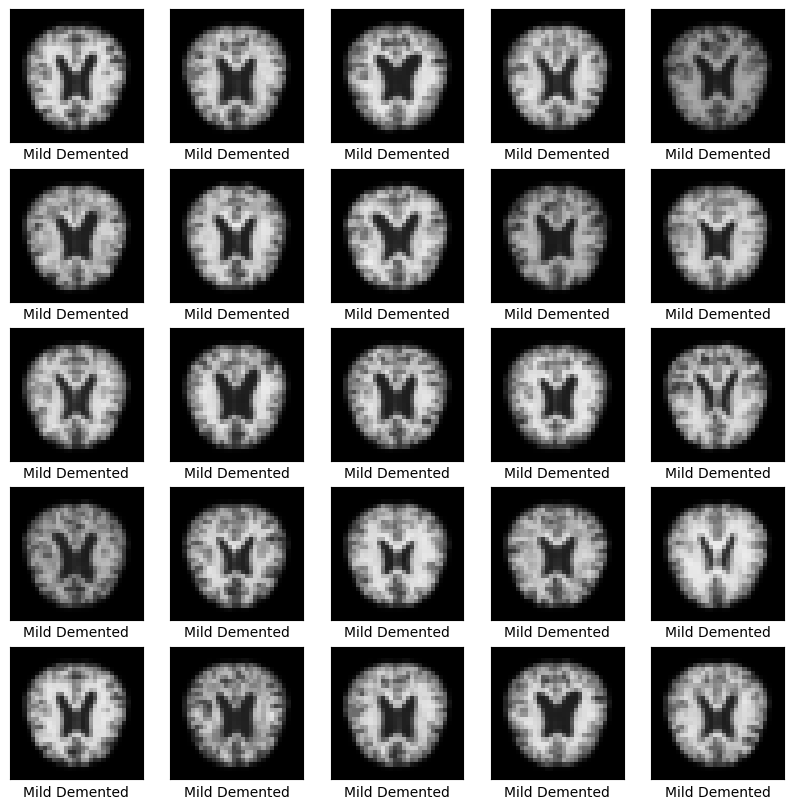

In [25]:
plt.figure(figsize=(10,10))

classes = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(X_val[i], (1, 2, 0)))
    plt.xlabel(classes[int(Y_val_predictions[i].item())])

Calculons maintenant la précision sur les données de validation

In [27]:
with torch.no_grad():
    for i, batch in enumerate(X_val_batches):
        batch = batch.to(device)
        labels = Y_val_batches_predictions[i].to(device)

        outputs = model(batch)
        predicted = outputs.argmax(axis = 1)
        diff = predicted - labels
        accuracy = len(diff[diff==0]) / len(diff)

print(f'Accuracy of the network on the validation images: {100 * accuracy} %')

Accuracy of the network on the validation images: 70.3125 %


### Pour aller plus loin...

Vous êtes arrivés au bout du TP mais ce n'est pas fini ! Dans un premier temps, vous pouvez utiliser une autre loss, la `negative-log likelihood` (cf documentation : https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). Cette loss est particulièrement adapté à un problème de classification et donc plus efficace que la MSE. Ensuite, c'est à vous de jouer : vous pouvez essayer d'améliorer votre réseau pour maximiser l'accuracy. Ajoutez des couches, changez la profondeur, le padding... Soyez inventifs !


Attention néanmoins, si vous utilisez la `negative-log likelihood`, il faudra modifier légèrement votre modèle : la dernière couche d'activation n'est plus softmax mais `logsoftmax`. De plus, avec cette loss, pas besoin de l'encodage onehot, tout se fait directement avec les labels de base, vous remplacez donc Y_train_batches par Y_train_batches_prediction dans votre boucle d'entraînement.